In [2]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

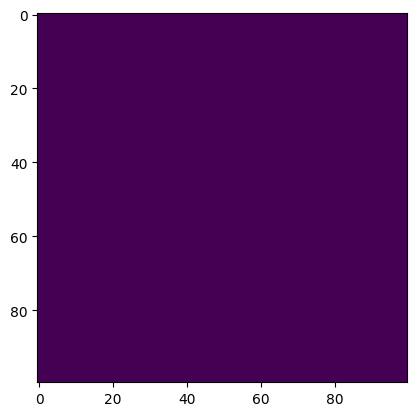

In [4]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [5]:
transducers = []
freqs = np.arange(1e6, 15e6, 0.5e6)
for i, freq in enumerate(freqs):
    transducers.append(transducer.Planewave(max_frequency=freq,
                                          elements = 32, 
                                          width = 20e-3,
                                          height =  20e-3,
                                          sensor_sampling_scheme = 'not_centroid', 
                                          sweep = 0,
                                          ray_num = 1, 
                                          imaging_ndims = 2,
                                          focus_elevation = 20e-3))
    transducers[i].make_sensor_coords(test_phantom.baseline[0])


In [6]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
for i, t in enumerate(test_transducer_set.transducers):
    test_transducer_set.assign_pose(i, geometry.Transform([0, 0, 0], [0, 0, 0]))

In [7]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')

In [8]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,60e-3,20e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [9]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/beam_width_test',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

In [9]:
test_experiment = experiment.Experiment.load('../experiment_files/beam_width_test')
test_experiment.run(dry=True)

Number of simulation results (7) is less than the expected number of simulation results (28), are you sure the simulation finished running?
dry run of simulation


  0%|          | 0/28 [00:00<?, ?it/s]

In [10]:
test_experiment.run(repeat=False)

running with 1 workers

preparation for sim    7 completed in         1006.77 seconds

preparation for sim    8 completed in         1306.35 seconds



┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                          1296 x 1024 x 512 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   8802 │
├───────────────────────────────────────────────────────────────┤
│         

Process run:
Traceback (most recent call last):
  File "/home/trevor/miniconda3/envs/musik/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/trevor/miniconda3/envs/musik/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/trevor/repos/MUSiK/debugging/../core/experiment.py", line 260, in run_worker
    simulation.run()
  File "/home/trevor/repos/MUSiK/debugging/../core/simulation.py", line 201, in run
    self.__run_by_index(self.index, dry=self.dry)
  File "/home/trevor/repos/MUSiK/debugging/../core/simulation.py", line 306, in __run_simulation
    sensor_data = kwave.kspaceFirstOrder3D.kspaceFirstOrder3D(
  File "/home/trevor/repos/MUSiK/debugging/../core/simulation.py", line 234, in __run_by_index
    time_array, signals, other_signals = self.__run_simulation(self.prepped_simulation, self.additional_keys)
  File "/home/trevor/repos/MUSiK/debugging/../k-wave-python/kwave/k

KeyboardInterrupt: 

In [ ]:
test_experiment.add_results()

In [ ]:
im = test_reconstruction.results[0][1]

In [ ]:
im.shape

(32, 1272)

In [28]:
for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
    plt.imshow(im[:,:,frame], cmap='bwr')
    plt.colorbar()
    plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
    plt.close()

  0%|          | 0/128 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed